# Aula de Spark: Análise de Veículos Elétricos

Este notebook demonstra o processamento de dados de veículos elétricos comparando:
- Processamento tradicional com Python puro
- Processamento com Apache Spark

## Dataset
Dados de veículos elétricos registrados no estado de Washington (EUA).

**Estrutura dos dados:**
- VIN parcial, Condado, Cidade, Estado, CEP
- Ano, Marca, Modelo
- Tipo de veículo elétrico (BEV/PHEV)
- Elegibilidade para incentivos
- Alcance elétrico, MSRP
- Localização geográfica

## 1. Setup e Importações

In [3]:
# Baixar dados do JSON se não existir
import os
import requests

# Download do arquivo JSON se não existir
if not os.path.exists('data/electric_vehicles.json'):
    print("Baixando dados...")
    os.makedirs('data', exist_ok=True)
    
    # URL do dataset (substitua pela URL correta)
    url = "https://data.wa.gov/api/views/f6w7-q2d2/rows.json?accessType=DOWNLOAD"
    
    response = requests.get(url)
    if response.status_code == 200:
        with open('data/electric_vehicles.json', 'w') as f:
            f.write(response.text)
        print("✅ Dados baixados com sucesso!")
    else:
        print(f"❌ Erro ao baixar dados: {response.status_code}")
else:
    print("✅ Dados já existem localmente")

import json
import time
import pandas as pd
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações para gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

✅ Dados já existem localmente


## 2. Carregamento dos Dados

In [4]:
# Carregando o arquivo JSON
with open('data/electric_vehicles.json', 'r') as f:
    data = json.load(f)

print(f"Metadados do dataset: {data['meta']['view']['name']}")
print(f"Descrição: {data['meta']['view']['description'][:100]}...")
print(f"Número de registros: {len(data['data'])}")

Metadados do dataset: Electric Vehicle Population Data
Descrição: This dataset shows the Battery Electric Vehicles (BEVs) and Plug-in Hybrid Electric Vehicles (PHEVs)...
Número de registros: 247344


In [5]:
# Extraindo e estruturando os dados
raw_data = data['data']

# Definindo os índices das colunas baseado na estrutura observada
columns = {
    'vin': 8,
    'county': 9,
    'city': 10,
    'state': 11,
    'postal_code': 12,
    'model_year': 13,
    'make': 14,
    'model': 15,
    'ev_type': 16,
    'cafv_eligibility': 17,
    'electric_range': 18,
    'base_msrp': 19,
    'legislative_district': 20,
    'dol_vehicle_id': 21,
    'geocoded_column': 22,
    'electric_utility': 23,
    'census_tract': 24
}

print("Exemplo de registro:")
for key, idx in columns.items():
    print(f"{key}: {raw_data[0][idx]}")

Exemplo de registro:
vin: 1N4BZ0CP5G
county: King
city: Seattle
state: WA
postal_code: 98125
model_year: 2016
make: NISSAN
model: LEAF
ev_type: Battery Electric Vehicle (BEV)
cafv_eligibility: Clean Alternative Fuel Vehicle Eligible
electric_range: 84
base_msrp: 0
legislative_district: 46
dol_vehicle_id: 349455557
geocoded_column: POINT (-122.30253 47.72656)
electric_utility: CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA)
census_tract: 53033000202


## 3. Processamento SEM Spark (Python Puro)

Vamos implementar várias análises usando apenas Python nativo para depois comparar com Spark.

In [6]:
def processar_sem_spark():
    """Análises usando Python puro"""
    
    start_time = time.time()
    
    # 1. Contagem por marca
    marcas = Counter()
    for row in raw_data:
        marca = row[columns['make']]
        if marca:
            marcas[marca] += 1
    
    # 2. Contagem por tipo de veículo elétrico
    tipos_ev = Counter()
    for row in raw_data:
        tipo = row[columns['ev_type']]
        if tipo:
            tipos_ev[tipo] += 1
    
    # 3. Alcance elétrico médio por marca (top 5 marcas)
    top_marcas = [marca for marca, _ in marcas.most_common(5)]
    alcance_por_marca = defaultdict(list)
    
    for row in raw_data:
        marca = row[columns['make']]
        alcance = row[columns['electric_range']]
        
        if marca in top_marcas and alcance and str(alcance).isdigit():
            alcance_por_marca[marca].append(int(alcance))
    
    # Calculando médias
    alcance_medio = {}
    for marca, alcances in alcance_por_marca.items():
        if alcances:
            alcance_medio[marca] = sum(alcances) / len(alcances)
    
    # 4. Distribuição por ano
    anos = Counter()
    for row in raw_data:
        ano = row[columns['model_year']]
        if ano and str(ano).isdigit():
            anos[int(ano)] += 1
    
    # 5. Top 10 cidades
    cidades = Counter()
    for row in raw_data:
        cidade = row[columns['city']]
        if cidade:
            cidades[cidade] += 1
    
    end_time = time.time()
    
    return {
        'tempo_execucao': end_time - start_time,
        'top_marcas': marcas.most_common(10),
        'tipos_ev': tipos_ev.most_common(),
        'alcance_medio': alcance_medio,
        'distribuicao_anos': dict(anos.most_common()),
        'top_cidades': cidades.most_common(10)
    }

# Executando análise sem Spark
resultado_python = processar_sem_spark()
print(f"\n🐍 PROCESSAMENTO PYTHON PURO")
print(f"Tempo de execução: {resultado_python['tempo_execucao']:.4f} segundos")
print(f"\nTop 5 marcas:")
for marca, count in resultado_python['top_marcas'][:5]:
    print(f"  {marca}: {count:,} veículos")


🐍 PROCESSAMENTO PYTHON PURO
Tempo de execução: 0.5645 segundos

Top 5 marcas:
  TESLA: 105,001 veículos
  CHEVROLET: 17,840 veículos
  NISSAN: 15,892 veículos
  FORD: 13,270 veículos
  KIA: 11,978 veículos


## 4. Setup do Spark

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, desc, when, isnan, isnull
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

# Criando sessão Spark
spark = SparkSession.builder \
    .appName("AnaliseVeiculosEletricos") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()

print(f"🚀 Spark inicializado - Versão: {spark.version}")
print(f"Spark UI disponível em: {spark.sparkContext.uiWebUrl}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/06/14 03:14:30 WARN Utils: Your hostname, codespaces-e244e7, resolves to a loopback address: 127.0.0.1; using 10.0.2.100 instead (on interface eth0)
25/06/14 03:14:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/14 03:14:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


🚀 Spark inicializado - Versão: 4.0.0
Spark UI disponível em: http://4de482d4-a852-42d6-91b7-6413f050a846.internal.cloudapp.net:4040


## 5. Processamento COM Spark

In [8]:
# Criando DataFrame com tratamento adequado de tipos
df_data = []
for row in raw_data:
    # Função auxiliar para converter valores numéricos
    def safe_int(value):
        if value is None or value == "" or value == "0":
            return None
        try:
            return int(value)
        except (ValueError, TypeError):
            return None
    
    # Criando um dicionário com apenas os campos que nos interessam
    row_dict = {
        'vin': row[8] if len(row) > 8 and row[8] else None,
        'county': row[9] if len(row) > 9 and row[9] else None,
        'city': row[10] if len(row) > 10 and row[10] else None,
        'state': row[11] if len(row) > 11 and row[11] else None,
        'postal_code': row[12] if len(row) > 12 and row[12] else None,
        'model_year': safe_int(row[13]) if len(row) > 13 else None,
        'make': row[14] if len(row) > 14 and row[14] else None,
        'model': row[15] if len(row) > 15 and row[15] else None,
        'ev_type': row[16] if len(row) > 16 and row[16] else None,
        'cafv_eligibility': row[17] if len(row) > 17 and row[17] else None,
        'electric_range': safe_int(row[18]) if len(row) > 18 else None,
        'base_msrp': row[19] if len(row) > 19 and row[19] else None,
        'legislative_district': row[20] if len(row) > 20 and row[20] else None,
        'dol_vehicle_id': row[21] if len(row) > 21 and row[21] else None,
        'geocoded_column': row[22] if len(row) > 22 and row[22] else None,
        'electric_utility': row[23] if len(row) > 23 and row[23] else None,
        'census_tract': row[24] if len(row) > 24 and row[24] else None
    }
    df_data.append(row_dict)

# Criando DataFrame Spark a partir dos dicionários
df = spark.createDataFrame(df_data)

print(f"DataFrame criado com {df.count():,} registros")
print(f"Número de partições: {df.rdd.getNumPartitions()}")

# Verificando schema
print("\\nSchema do DataFrame:")
df.printSchema()

# Cache do DataFrame para reutilização
df.cache()
df.show(5, truncate=False)

25/06/14 03:14:53 WARN TaskSetManager: Stage 0 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.


DataFrame criado com 247,344 registros
Número de partições: 4
\nSchema do DataFrame:
root
 |-- base_msrp: string (nullable = true)
 |-- cafv_eligibility: string (nullable = true)
 |-- census_tract: string (nullable = true)
 |-- city: string (nullable = true)
 |-- county: string (nullable = true)
 |-- dol_vehicle_id: string (nullable = true)
 |-- electric_range: long (nullable = true)
 |-- electric_utility: string (nullable = true)
 |-- ev_type: string (nullable = true)
 |-- geocoded_column: string (nullable = true)
 |-- legislative_district: string (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- model_year: long (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- state: string (nullable = true)
 |-- vin: string (nullable = true)



25/06/14 03:14:55 WARN TaskSetManager: Stage 3 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.


+---------+---------------------------------------+------------+---------+--------+--------------+--------------+---------------------------------------------+--------------------------------------+---------------------------+--------------------+------+--------+----------+-----------+-----+----------+
|base_msrp|cafv_eligibility                       |census_tract|city     |county  |dol_vehicle_id|electric_range|electric_utility                             |ev_type                               |geocoded_column            |legislative_district|make  |model   |model_year|postal_code|state|vin       |
+---------+---------------------------------------+------------+---------+--------+--------------+--------------+---------------------------------------------+--------------------------------------+---------------------------+--------------------+------+--------+----------+-----------+-----+----------+
|0        |Clean Alternative Fuel Vehicle Eligible|53033000202 |Seattle  |King    |34945

In [9]:
def processar_com_spark():
    """Análises usando Spark"""
    
    start_time = time.time()
    
    # Importando as funções do Spark para evitar conflitos
    from pyspark.sql.functions import count as spark_count, avg, desc
    
    # 1. Contagem por marca
    top_marcas = df.filter(col("make").isNotNull()) \
                   .groupBy("make") \
                   .agg(spark_count("*").alias("count")) \
                   .orderBy(desc("count")) \
                   .limit(10) \
                   .collect()
    
    # 2. Contagem por tipo de veículo elétrico
    tipos_ev = df.filter(col("ev_type").isNotNull()) \
                 .groupBy("ev_type") \
                 .agg(spark_count("*").alias("count")) \
                 .orderBy(desc("count")) \
                 .collect()
    
    # 3. Alcance elétrico médio por marca (top 5 marcas)
    top_5_marcas = [row['make'] for row in top_marcas[:5]]
    
    alcance_medio = df.filter(col("make").isin(top_5_marcas)) \
                      .filter(col("electric_range").isNotNull()) \
                      .filter(col("electric_range") > 0) \
                      .groupBy("make") \
                      .agg(avg("electric_range").alias("avg_range")) \
                      .collect()
    
    # 4. Distribuição por ano
    distribuicao_anos = df.filter(col("model_year").isNotNull()) \
                          .groupBy("model_year") \
                          .agg(spark_count("*").alias("count")) \
                          .orderBy("model_year") \
                          .collect()
    
    # 5. Top 10 cidades
    top_cidades = df.filter(col("city").isNotNull()) \
                    .groupBy("city") \
                    .agg(spark_count("*").alias("count")) \
                    .orderBy(desc("count")) \
                    .limit(10) \
                    .collect()
    
    end_time = time.time()
    
    return {
        'tempo_execucao': end_time - start_time,
        'top_marcas': [(row['make'], row['count']) for row in top_marcas],
        'tipos_ev': [(row['ev_type'], row['count']) for row in tipos_ev],
        'alcance_medio': {row['make']: row['avg_range'] for row in alcance_medio},
        'distribuicao_anos': {row['model_year']: row['count'] for row in distribuicao_anos},
        'top_cidades': [(row['city'], row['count']) for row in top_cidades]
    }

# Executando análise com Spark
resultado_spark = processar_com_spark()
print(f"\n⚡ PROCESSAMENTO SPARK")
print(f"Tempo de execução: {resultado_spark['tempo_execucao']:.4f} segundos")
print(f"\nTop 5 marcas:")
for marca, count in resultado_spark['top_marcas'][:5]:
    print(f"  {marca}: {count:,} veículos")

25/06/14 03:14:57 WARN TaskSetManager: Stage 4 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.
25/06/14 03:14:58 WARN TaskSetManager: Stage 5 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.
25/06/14 03:14:59 WARN TaskSetManager: Stage 8 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.
25/06/14 03:15:00 WARN TaskSetManager: Stage 16 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.
25/06/14 03:15:00 WARN TaskSetManager: Stage 19 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.
25/06/14 03:15:01 WARN TaskSetManager: Stage 27 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.



⚡ PROCESSAMENTO SPARK
Tempo de execução: 4.3574 segundos

Top 5 marcas:
  TESLA: 105,001 veículos
  CHEVROLET: 17,840 veículos
  NISSAN: 15,892 veículos
  FORD: 13,270 veículos
  KIA: 11,978 veículos


## 6. Comparação de Performance

In [10]:
# Comparando tempos de execução
tempo_python = resultado_python['tempo_execucao']
tempo_spark = resultado_spark['tempo_execucao']

print("📊 COMPARAÇÃO DE PERFORMANCE")
print(f"Python puro: {tempo_python:.4f}s")
print(f"Spark:       {tempo_spark:.4f}s")
print(f"Diferença:   {abs(tempo_python - tempo_spark):.4f}s")

if tempo_python < tempo_spark:
    speedup = tempo_spark / tempo_python
    print(f"Python foi {speedup:.2f}x mais rápido")
else:
    speedup = tempo_python / tempo_spark
    print(f"Spark foi {speedup:.2f}x mais rápido")

print("\n💡 OBSERVAÇÕES:")
print("- Para datasets pequenos, Python puro pode ser mais rápido devido ao overhead do Spark")
print("- Spark brilha com datasets maiores (GB/TB) e processamento distribuído")
print("- Spark oferece melhor escalabilidade e recursos como caching, SQL, etc.")

📊 COMPARAÇÃO DE PERFORMANCE
Python puro: 0.5645s
Spark:       4.3574s
Diferença:   3.7929s
Python foi 7.72x mais rápido

💡 OBSERVAÇÕES:
- Para datasets pequenos, Python puro pode ser mais rápido devido ao overhead do Spark
- Spark brilha com datasets maiores (GB/TB) e processamento distribuído
- Spark oferece melhor escalabilidade e recursos como caching, SQL, etc.


## 7. Análise Exploratória dos Dados (EDA) com Spark

In [11]:
# Estatísticas gerais do dataset
print("📈 ESTATÍSTICAS GERAIS")
print(f"Total de registros: {df.count():,}")
print(f"Número de colunas: {len(df.columns)}")

# Verificando dados nulos - corrigido para lidar com tipos adequadamente
print("\n🔍 DADOS NULOS POR COLUNA:")
colunas_interesse = ['make', 'model', 'model_year', 'ev_type', 'electric_range', 'city', 'county']

for coluna in colunas_interesse:
    # Para colunas string, verificamos nulos e strings vazias
    if coluna in ['make', 'model', 'ev_type', 'city', 'county']:
        null_count = df.filter(col(coluna).isNull() | (col(coluna) == "")).count()
    else:
        # Para colunas numéricas, verificamos apenas nulos
        null_count = df.filter(col(coluna).isNull()).count()
    
    total = df.count()
    percentual = (null_count / total) * 100
    print(f"  {coluna}: {null_count:,} ({percentual:.1f}%)")

📈 ESTATÍSTICAS GERAIS


25/06/14 03:15:01 WARN TaskSetManager: Stage 30 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.


Total de registros: 247,344
Número de colunas: 17

🔍 DADOS NULOS POR COLUNA:


25/06/14 03:15:01 WARN TaskSetManager: Stage 33 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.
25/06/14 03:15:01 WARN TaskSetManager: Stage 36 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.


  make: 0 (0.0%)


25/06/14 03:15:02 WARN TaskSetManager: Stage 39 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.
25/06/14 03:15:02 WARN TaskSetManager: Stage 42 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.


  model: 0 (0.0%)


25/06/14 03:15:02 WARN TaskSetManager: Stage 45 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.
25/06/14 03:15:02 WARN TaskSetManager: Stage 48 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.
25/06/14 03:15:02 WARN TaskSetManager: Stage 51 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.


  model_year: 0 (0.0%)


25/06/14 03:15:02 WARN TaskSetManager: Stage 54 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.
25/06/14 03:15:02 WARN TaskSetManager: Stage 57 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.


  ev_type: 0 (0.0%)


25/06/14 03:15:03 WARN TaskSetManager: Stage 60 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.
25/06/14 03:15:03 WARN TaskSetManager: Stage 63 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.


  electric_range: 149,654 (60.5%)


25/06/14 03:15:03 WARN TaskSetManager: Stage 66 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.
25/06/14 03:15:03 WARN TaskSetManager: Stage 69 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.
25/06/14 03:15:03 WARN TaskSetManager: Stage 72 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.


  city: 4 (0.0%)
  county: 4 (0.0%)


In [12]:
# Análise dos tipos de veículos elétricos
from pyspark.sql.functions import count as spark_count, desc

print("🔋 TIPOS DE VEÍCULOS ELÉTRICOS")
df.groupBy("ev_type") \
  .agg(spark_count("*").alias("count")) \
  .orderBy(desc("count")) \
  .show()

# Distribuição por elegibilidade CAFV
print("🎯 ELEGIBILIDADE PARA INCENTIVOS")
df.groupBy("cafv_eligibility") \
  .agg(spark_count("*").alias("count")) \
  .orderBy(desc("count")) \
  .show(truncate=False)

🔋 TIPOS DE VEÍCULOS ELÉTRICOS


25/06/14 03:15:03 WARN TaskSetManager: Stage 75 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+------+
|             ev_type| count|
+--------------------+------+
|Battery Electric ...|197146|
|Plug-in Hybrid El...| 50198|
+--------------------+------+

🎯 ELEGIBILIDADE PARA INCENTIVOS
+------------------------------------------------------------+------+
|cafv_eligibility                                            |count |
+------------------------------------------------------------+------+
|Eligibility unknown as battery range has not been researched|149634|
|Clean Alternative Fuel Vehicle Eligible                     |74523 |
|Not eligible due to low battery range                       |23187 |
+------------------------------------------------------------+------+



25/06/14 03:15:04 WARN TaskSetManager: Stage 78 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.


In [13]:
# Análise temporal: crescimento por ano
print("📅 CRESCIMENTO ANUAL DE REGISTROS")
df.filter(col("model_year").isNotNull()) \
  .filter(col("model_year") >= 2010) \
  .groupBy("model_year") \
  .agg(spark_count("*").alias("registros")) \
  .orderBy("model_year") \
  .show(20)

# Top marcas por tipo de veículo
print("🏭 TOP MARCAS POR TIPO DE VEÍCULO")
df.filter(col("make").isNotNull() & col("ev_type").isNotNull()) \
  .groupBy("ev_type", "make") \
  .agg(spark_count("*").alias("count")) \
  .orderBy("ev_type", desc("count")) \
  .show(20, truncate=False)

📅 CRESCIMENTO ANUAL DE REGISTROS


25/06/14 03:15:04 WARN TaskSetManager: Stage 81 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.


+----------+---------+
|model_year|registros|
+----------+---------+
|      2010|       23|
|      2011|      656|
|      2012|     1462|
|      2013|     4168|
|      2014|     3364|
|      2015|     4613|
|      2016|     5302|
|      2017|     8755|
|      2018|    14504|
|      2019|    11055|
|      2020|    12390|
|      2021|    20794|
|      2022|    29337|
|      2023|    59088|
|      2024|    49799|
|      2025|    20820|
|      2026|     1186|
+----------+---------+

🏭 TOP MARCAS POR TIPO DE VEÍCULO


25/06/14 03:15:04 WARN TaskSetManager: Stage 84 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.


+------------------------------+-------------+------+
|ev_type                       |make         |count |
+------------------------------+-------------+------+
|Battery Electric Vehicle (BEV)|TESLA        |105001|
|Battery Electric Vehicle (BEV)|NISSAN       |15892 |
|Battery Electric Vehicle (BEV)|CHEVROLET    |13154 |
|Battery Electric Vehicle (BEV)|FORD         |9490  |
|Battery Electric Vehicle (BEV)|KIA          |8375  |
|Battery Electric Vehicle (BEV)|RIVIAN       |7491  |
|Battery Electric Vehicle (BEV)|HYUNDAI      |6893  |
|Battery Electric Vehicle (BEV)|VOLKSWAGEN   |6427  |
|Battery Electric Vehicle (BEV)|BMW          |4330  |
|Battery Electric Vehicle (BEV)|AUDI         |2599  |
|Battery Electric Vehicle (BEV)|VOLVO        |2191  |
|Battery Electric Vehicle (BEV)|SUBARU       |2007  |
|Battery Electric Vehicle (BEV)|MERCEDES-BENZ|1901  |
|Battery Electric Vehicle (BEV)|TOYOTA       |1561  |
|Battery Electric Vehicle (BEV)|HONDA        |1504  |
|Battery Electric Vehicle (B

## 8. Operações Avançadas do Spark

In [14]:
# Demonstrando diferentes tipos de operações Spark

print("🔧 TRANSFORMAÇÕES E AÇÕES DO SPARK")

# 1. TRANSFORMAÇÕES (lazy evaluation)
print("\n1. TRANSFORMAÇÕES (não executadas até uma ação):")

# Filter + Select
tesla_df = df.filter(col("make") == "TESLA") \
             .select("model", "model_year", "electric_range", "city")
print(f"   - Criado DataFrame filtrado para Tesla (lazy)")

# WithColumn (criando nova coluna)
df_categorized = df.withColumn(
    "range_category",
    when(col("electric_range") >= 300, "Longo Alcance")
    .when(col("electric_range") >= 200, "Médio Alcance")
    .when(col("electric_range") >= 100, "Baixo Alcance")
    .otherwise("Muito Baixo Alcance")
)
print(f"   - Adicionada coluna de categoria de alcance (lazy)")

# 2. AÇÕES (trigger execution)
print("\n2. AÇÕES (executam as transformações):")

# Count
tesla_count = tesla_df.count()
print(f"   - count(): {tesla_count:,} Teslas registradas")

# Show
print(f"   - show(): Primeiros registros Tesla")
tesla_df.orderBy(desc("electric_range")).show(5, truncate=False)

# Collect
range_stats = df_categorized.groupBy("range_category") \
                           .agg(spark_count("*").alias("count")) \
                           .orderBy(desc("count")) \
                           .collect()

print(f"   - collect(): Distribuição por categoria de alcance")
for row in range_stats:
    print(f"     {row['range_category']}: {row['count']:,}")

🔧 TRANSFORMAÇÕES E AÇÕES DO SPARK

1. TRANSFORMAÇÕES (não executadas até uma ação):
   - Criado DataFrame filtrado para Tesla (lazy)
   - Adicionada coluna de categoria de alcance (lazy)

2. AÇÕES (executam as transformações):


25/06/14 03:15:05 WARN TaskSetManager: Stage 87 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.
25/06/14 03:15:05 WARN TaskSetManager: Stage 90 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.


   - count(): 105,001 Teslas registradas
   - show(): Primeiros registros Tesla
+-------+----------+--------------+---------+
|model  |model_year|electric_range|city     |
+-------+----------+--------------+---------+
|MODEL S|2020      |337           |Spokane  |
|MODEL S|2020      |337           |Olalla   |
|MODEL S|2020      |337           |Sammamish|
|MODEL S|2020      |337           |Seattle  |
|MODEL S|2020      |337           |Olympia  |
+-------+----------+--------------+---------+
only showing top 5 rows


25/06/14 03:15:05 WARN TaskSetManager: Stage 91 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.


   - collect(): Distribuição por categoria de alcance
     Muito Baixo Alcance: 208,695
     Médio Alcance: 30,674
     Baixo Alcance: 5,276
     Longo Alcance: 2,699


In [15]:
# Demonstrando Window Functions
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, row_number, lag, lead

print("🪟 WINDOW FUNCTIONS")

# Ranking de marcas por ano
window_spec = Window.partitionBy("model_year").orderBy(desc("count"))

marca_por_ano = df.filter(col("model_year").isNotNull()) \
                  .filter(col("model_year") >= 2020) \
                  .groupBy("model_year", "make") \
                  .agg(spark_count("*").alias("count")) \
                  .withColumn("rank", rank().over(window_spec)) \
                  .filter(col("rank") <= 3) \
                  .orderBy("model_year", "rank")

print("Top 3 marcas por ano (2020+):")
marca_por_ano.show(20, truncate=False)

🪟 WINDOW FUNCTIONS
Top 3 marcas por ano (2020+):


25/06/14 03:15:05 WARN TaskSetManager: Stage 99 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.


+----------+----------+-----+----+
|model_year|make      |count|rank|
+----------+----------+-----+----+
|2020      |TESLA     |7131 |1   |
|2020      |CHEVROLET |1644 |2   |
|2020      |NISSAN    |704  |3   |
|2021      |TESLA     |11649|1   |
|2021      |TOYOTA    |1202 |2   |
|2021      |VOLKSWAGEN|1087 |3   |
|2022      |TESLA     |14086|1   |
|2022      |KIA       |2152 |2   |
|2022      |FORD      |1785 |3   |
|2023      |TESLA     |27762|1   |
|2023      |FORD      |4280 |2   |
|2023      |CHEVROLET |3202 |3   |
|2024      |TESLA     |16757|1   |
|2024      |KIA       |3776 |2   |
|2024      |TOYOTA    |3161 |3   |
|2025      |TESLA     |8218 |1   |
|2025      |RIVIAN    |1689 |2   |
|2025      |BMW       |1575 |3   |
|2026      |TESLA     |1181 |1   |
|2026      |CADILLAC  |4    |2   |
+----------+----------+-----+----+
only showing top 20 rows


In [16]:
# Usando Spark SQL
print("🗣️ SPARK SQL")

# Registrando o DataFrame como uma tabela temporária
df.createOrReplaceTempView("electric_vehicles")

# Query SQL complexa
sql_query = """
SELECT 
    make,
    ev_type,
    COUNT(*) as total_vehicles,
    AVG(electric_range) as avg_range,
    MIN(model_year) as first_year,
    MAX(model_year) as last_year
FROM electric_vehicles 
WHERE make IS NOT NULL 
    AND ev_type IS NOT NULL 
    AND electric_range > 0
GROUP BY make, ev_type
HAVING COUNT(*) >= 100
ORDER BY total_vehicles DESC
LIMIT 15
"""

resultado_sql = spark.sql(sql_query)
print("Análise por marca e tipo (mín. 100 veículos):")
resultado_sql.show(truncate=False)

# Query geográfica
geo_query = """
SELECT 
    county,
    COUNT(*) as total,
    COUNT(CASE WHEN ev_type = 'Battery Electric Vehicle (BEV)' THEN 1 END) as bev_count,
    COUNT(CASE WHEN ev_type LIKE '%Plug-in Hybrid%' THEN 1 END) as phev_count,
    ROUND(AVG(electric_range), 1) as avg_range
FROM electric_vehicles 
WHERE county IS NOT NULL
GROUP BY county
ORDER BY total DESC
LIMIT 10
"""

print("\nDistribuição geográfica (top 10 condados):")
spark.sql(geo_query).show(truncate=False)

🗣️ SPARK SQL
Análise por marca e tipo (mín. 100 veículos):


25/06/14 03:15:06 WARN TaskSetManager: Stage 105 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.


+---------+--------------------------------------+--------------+------------------+----------+---------+
|make     |ev_type                               |total_vehicles|avg_range         |first_year|last_year|
+---------+--------------------------------------+--------------+------------------+----------+---------+
|TESLA    |Battery Electric Vehicle (BEV)        |25347         |241.30169250798912|2008      |2020     |
|NISSAN   |Battery Electric Vehicle (BEV)        |10221         |105.60835534683494|2011      |2020     |
|TOYOTA   |Plug-in Hybrid Electric Vehicle (PHEV)|8684          |32.296407185628745|2012      |2025     |
|JEEP     |Plug-in Hybrid Electric Vehicle (PHEV)|6086          |22.32007886953664 |2021      |2025     |
|BMW      |Plug-in Hybrid Electric Vehicle (PHEV)|6040          |40.154635761589404|2014      |2025     |
|CHEVROLET|Battery Electric Vehicle (BEV)        |5487          |237.86659376708585|2014      |2020     |
|CHEVROLET|Plug-in Hybrid Electric Vehicle (PH

25/06/14 03:15:06 WARN TaskSetManager: Stage 108 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.


+---------+------+---------+----------+---------+
|county   |total |bev_count|phev_count|avg_range|
+---------+------+---------+----------+---------+
|King     |122819|100935   |21884     |119.2    |
|Snohomish|30587 |25643    |4944      |119.9    |
|Pierce   |20534 |16058    |4476      |108.1    |
|Clark    |15055 |11275    |3780      |101.4    |
|Thurston |9081  |6913     |2168      |106.0    |
|Kitsap   |8375  |6359     |2016      |103.6    |
|Spokane  |6971  |4964     |2007      |91.7     |
|Whatcom  |6030  |4547     |1483      |103.7    |
|Benton   |3320  |2407     |913       |110.9    |
|Skagit   |2843  |2175     |668       |113.2    |
+---------+------+---------+----------+---------+



## 9. Visualizações

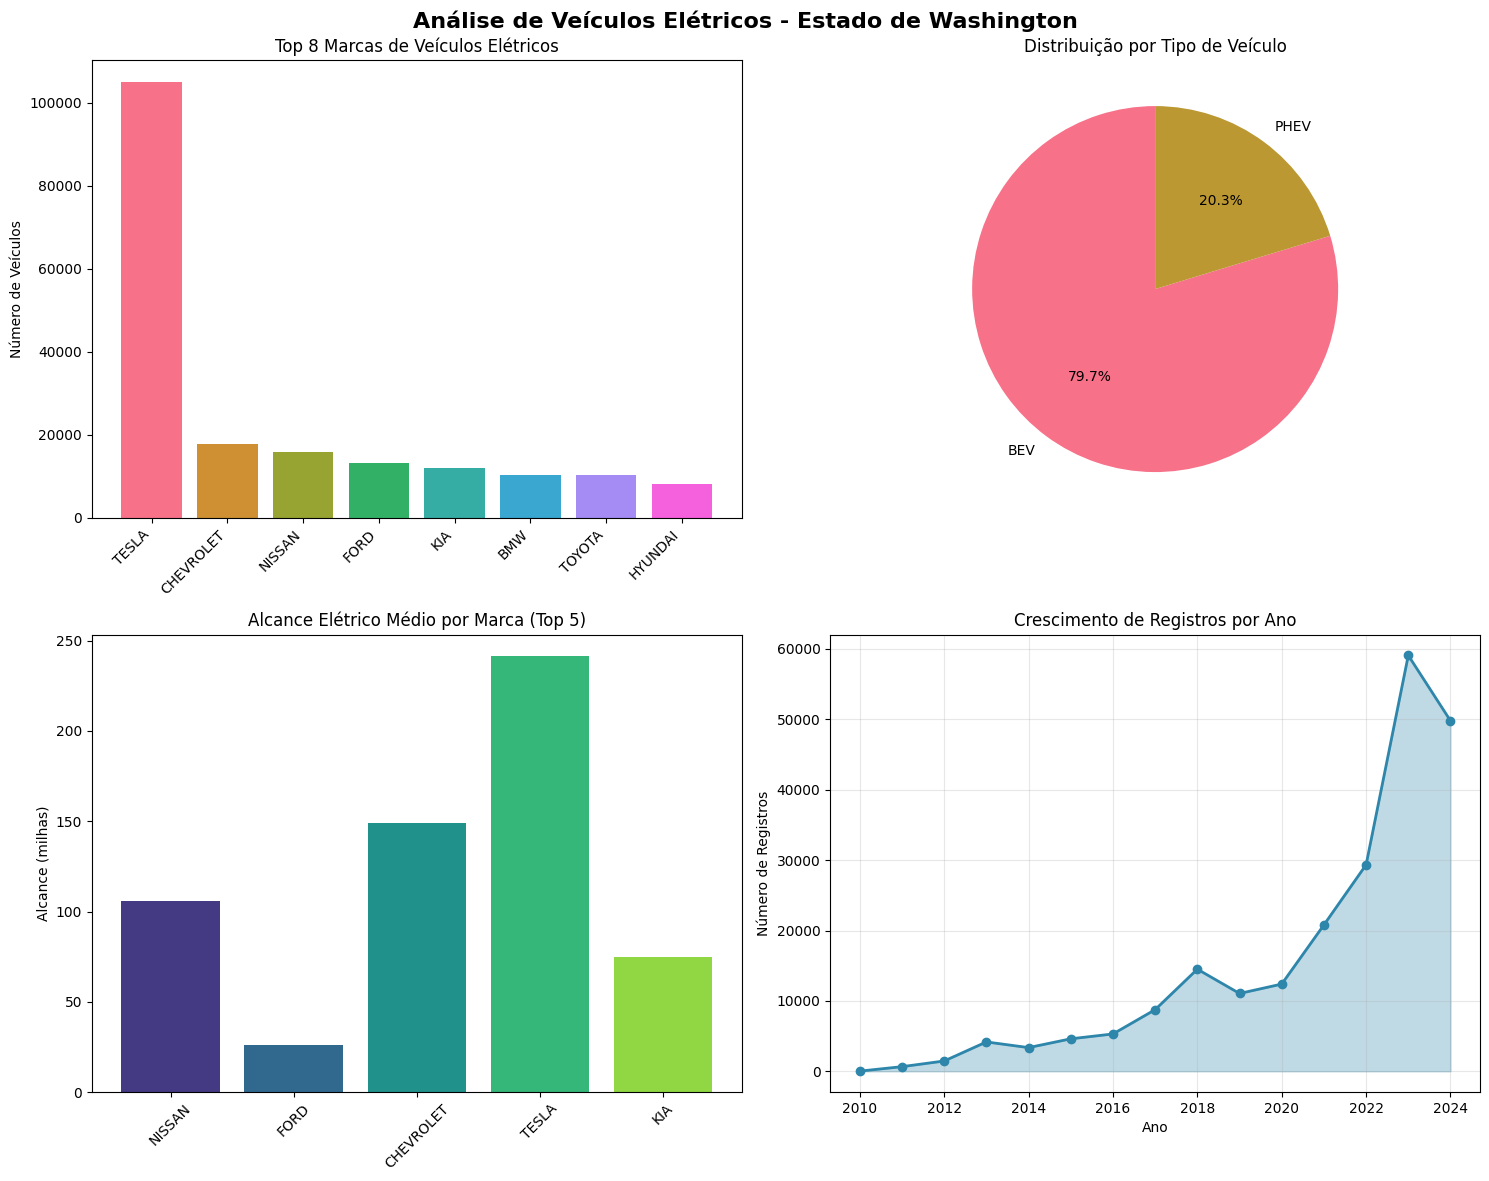


📊 RESUMO ESTATÍSTICO:
• Total de veículos analisados: 206,563
• Maior alcance médio: 241.3 milhas (TESLA)
• Anos com dados: 2010 - 2024
• Crescimento recente: 49,799 registros em 2024


In [17]:
# Convertendo resultados Spark para visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Configurando o estilo
plt.style.use('default')
sns.set_palette("husl")

# 1. Gráfico de barras: Top marcas
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análise de Veículos Elétricos - Estado de Washington', fontsize=16, fontweight='bold')

# Top marcas
marcas_data = resultado_spark['top_marcas'][:8]
marcas, counts = zip(*marcas_data)
ax1.bar(range(len(marcas)), counts, color=sns.color_palette("husl", len(marcas)))
ax1.set_title('Top 8 Marcas de Veículos Elétricos')
ax1.set_xticks(range(len(marcas)))
ax1.set_xticklabels(marcas, rotation=45, ha='right')
ax1.set_ylabel('Número de Veículos')

# Tipos de veículos
tipos_data = resultado_spark['tipos_ev']
tipos, tipo_counts = zip(*tipos_data)
tipos_short = [t.replace('Battery Electric Vehicle (BEV)', 'BEV').replace('Plug-in Hybrid Electric Vehicle (PHEV)', 'PHEV') for t in tipos]
ax2.pie(tipo_counts, labels=tipos_short, autopct='%1.1f%%', startangle=90)
ax2.set_title('Distribuição por Tipo de Veículo')

# Alcance médio por marca
alcance_data = resultado_spark['alcance_medio']
marcas_alcance = list(alcance_data.keys())
alcances = list(alcance_data.values())
ax3.bar(marcas_alcance, alcances, color=sns.color_palette("viridis", len(marcas_alcance)))
ax3.set_title('Alcance Elétrico Médio por Marca (Top 5)')
ax3.set_ylabel('Alcance (milhas)')
ax3.tick_params(axis='x', rotation=45)

# Crescimento temporal
anos_data = resultado_spark['distribuicao_anos']
anos_filtrados = {k: v for k, v in anos_data.items() if k >= 2010 and k <= 2024}
anos_ordenados = sorted(anos_filtrados.items())
anos, registros = zip(*anos_ordenados)
ax4.plot(anos, registros, marker='o', linewidth=2, markersize=6, color='#2E86AB')
ax4.fill_between(anos, registros, alpha=0.3, color='#2E86AB')
ax4.set_title('Crescimento de Registros por Ano')
ax4.set_xlabel('Ano')
ax4.set_ylabel('Número de Registros')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas adicionais
print("\n📊 RESUMO ESTATÍSTICO:")
total_veiculos = sum(count for _, count in resultado_spark['top_marcas'])
print(f"• Total de veículos analisados: {total_veiculos:,}")
print(f"• Maior alcance médio: {max(alcance_data.values()):.1f} milhas ({max(alcance_data, key=alcance_data.get)})")
print(f"• Anos com dados: {min(anos)} - {max(anos)}")
print(f"• Crescimento recente: {registros[-1]:,} registros em {anos[-1]}")

## 10. Otimizações e Melhores Práticas

In [18]:
print("⚡ OTIMIZAÇÕES E MELHORES PRÁTICAS DO SPARK")

# 1. Informações sobre particionamento
print(f"\n1. PARTICIONAMENTO:")
print(f"   • Número atual de partições: {df.rdd.getNumPartitions()}")
print(f"   • Registros por partição: ~{df.count() // df.rdd.getNumPartitions():,}")

# 2. Demonstrando reparticionamento
df_repartitioned = df.repartition(4, "make")
print(f"   • Após reparticionamento por 'make': {df_repartitioned.rdd.getNumPartitions()} partições")

# 3. Cache/Persist
from pyspark import StorageLevel
print(f"\n2. CACHE E PERSISTÊNCIA:")
print(f"   • DataFrame está cacheado: {df.is_cached}")

# Exemplo de diferentes níveis de cache
df_memory_only = df.persist(StorageLevel.MEMORY_ONLY)
df_memory_and_disk = df.persist(StorageLevel.MEMORY_AND_DISK)
print(f"   • Opções: MEMORY_ONLY, MEMORY_AND_DISK, DISK_ONLY, etc.")

# 4. Broadcast Join (exemplo conceitual)
print(f"\n3. BROADCAST JOINS:")
print(f"   • Para JOINs com tabelas pequenas (<200MB)")
print(f"   • Evita shuffle custoso")

# 5. Predicate Pushdown
print(f"\n4. PREDICATE PUSHDOWN:")
print(f"   • Filtros aplicados o mais cedo possível")
print(f"   • Reduz dados processados")

# Exemplo de query otimizada vs não otimizada
print(f"\n   Exemplo RUIM:")
print(f"   df.groupBy('make').count().filter(col('count') > 100)")

print(f"\n   Exemplo BOM:")
print(f"   df.filter(col('make').isNotNull()).groupBy('make').count().filter(col('count') > 100)")

# 6. Configurações importantes
print(f"\n5. CONFIGURAÇÕES IMPORTANTES:")
spark_configs = spark.sparkContext.getConf().getAll()
configs_importantes = {
    'spark.sql.adaptive.enabled': 'Otimização adaptativa',
    'spark.sql.adaptive.coalescePartitions.enabled': 'Coalescer partições pequenas',
    'spark.serializer': 'Serialização (recomendado: KryoSerializer)',
    'spark.sql.adaptive.skewJoin.enabled': 'Otimização para joins com skew'
}

for config, descricao in configs_importantes.items():
    valor = dict(spark_configs).get(config, 'não configurado')
    print(f"   • {config}: {valor} ({descricao})")

⚡ OTIMIZAÇÕES E MELHORES PRÁTICAS DO SPARK

1. PARTICIONAMENTO:
   • Número atual de partições: 4
   • Registros por partição: ~61,836


25/06/14 03:15:07 WARN TaskSetManager: Stage 111 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.
25/06/14 03:15:08 WARN TaskSetManager: Stage 114 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.


   • Após reparticionamento por 'make': 4 partições

2. CACHE E PERSISTÊNCIA:
   • DataFrame está cacheado: True
   • Opções: MEMORY_ONLY, MEMORY_AND_DISK, DISK_ONLY, etc.

3. BROADCAST JOINS:
   • Para JOINs com tabelas pequenas (<200MB)
   • Evita shuffle custoso

4. PREDICATE PUSHDOWN:
   • Filtros aplicados o mais cedo possível
   • Reduz dados processados

   Exemplo RUIM:
   df.groupBy('make').count().filter(col('count') > 100)

   Exemplo BOM:
   df.filter(col('make').isNotNull()).groupBy('make').count().filter(col('count') > 100)

5. CONFIGURAÇÕES IMPORTANTES:
   • spark.sql.adaptive.enabled: true (Otimização adaptativa)
   • spark.sql.adaptive.coalescePartitions.enabled: true (Coalescer partições pequenas)
   • spark.serializer: não configurado (Serialização (recomendado: KryoSerializer))
   • spark.sql.adaptive.skewJoin.enabled: não configurado (Otimização para joins com skew)


25/06/14 03:15:08 WARN CacheManager: Asked to cache already cached data.
25/06/14 03:15:08 WARN CacheManager: Asked to cache already cached data.


## 11. Análise de Performance e Monitoring

In [ ]:
print("📈 MONITORAMENTO E PERFORMANCE")

# 1. Informações do SparkContext
sc = spark.sparkContext
print(f"\n1. INFORMAÇÕES DA SESSÃO:")
print(f"   • Application ID: {sc.applicationId}")
print(f"   • Application Name: {sc.appName}")
print(f"   • Spark Version: {sc.version}")
print(f"   • Default Parallelism: {sc.defaultParallelism}")

# 2. Spark UI
print(f"\n2. MONITORAMENTO:")
print(f"   • Spark UI: {sc.uiWebUrl}")
print(f"   • Aqui você pode ver: Jobs, Stages, Storage, Environment, Executors")

# 3. Exemplo de análise de plano de execução
print(f"\n3. PLANO DE EXECUÇÃO:")
query_plan = df.filter(col("make") == "TESLA") \
               .groupBy("model") \
               .count() \
               .orderBy(desc("count"))

print("\nPlano lógico:")
query_plan.explain(True)

# 4. Medindo performance de diferentes operações
import time

def medir_tempo(operacao_nome, operacao_func):
    start = time.time()
    resultado = operacao_func()
    end = time.time()
    print(f"   • {operacao_nome}: {(end-start)*1000:.2f}ms")
    return resultado

print(f"\n4. BENCHMARK DE OPERAÇÕES:")

# Count
medir_tempo("Count total", lambda: df.count())

# Filter + Count
medir_tempo("Filter Tesla + Count", lambda: df.filter(col("make") == "TESLA").count())

# GroupBy
medir_tempo("GroupBy make", lambda: df.groupBy("make").count().collect())

# Join (self-join como exemplo)
medir_tempo("Self-join", lambda: df.alias("a").join(df.alias("b"), col("a.make") == col("b.make")).count())

📈 MONITORAMENTO E PERFORMANCE

1. INFORMAÇÕES DA SESSÃO:
   • Application ID: local-1749870872210
   • Application Name: AnaliseVeiculosEletricos
   • Spark Version: 4.0.0
   • Default Parallelism: 4

2. MONITORAMENTO:
   • Spark UI: http://4de482d4-a852-42d6-91b7-6413f050a846.internal.cloudapp.net:4040
   • Aqui você pode ver: Jobs, Stages, Storage, Environment, Executors

3. PLANO DE EXECUÇÃO:

Plano lógico:
== Parsed Logical Plan ==
'Sort ['count DESC NULLS LAST], true
+- Aggregate [model#12], [model#12, count(1) AS count#14807L]
   +- Filter (make#11 = TESLA)
      +- LogicalRDD [base_msrp#0, cafv_eligibility#1, census_tract#2, city#3, county#4, dol_vehicle_id#5, electric_range#6L, electric_utility#7, ev_type#8, geocoded_column#9, legislative_district#10, make#11, model#12, model_year#13L, postal_code#14, state#15, vin#16], false

== Analyzed Logical Plan ==
model: string, count: bigint
Sort [count#14807L DESC NULLS LAST], true
+- Aggregate [model#12], [model#12, count(1) AS count#

25/06/14 03:15:08 WARN TaskSetManager: Stage 115 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.
25/06/14 03:15:08 WARN TaskSetManager: Stage 118 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.


   • Filter Tesla + Count: 133.28ms


25/06/14 03:15:08 WARN TaskSetManager: Stage 121 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.


   • GroupBy make: 250.61ms


25/06/14 03:15:09 WARN TaskSetManager: Stage 124 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.
25/06/14 03:15:09 WARN TaskSetManager: Stage 125 contains a task of very large size (16147 KiB). The maximum recommended task size is 1000 KiB.


## 12. Conclusões e Próximos Passos

In [ ]:
print("🎯 CONCLUSÕES DA AULA DE SPARK\n")

print("✅ O QUE APRENDEMOS:")
print("   1. Diferenças entre processamento Python puro vs Spark")
print("   2. Conceitos fundamentais: RDDs, DataFrames, transformações vs ações")
print("   3. Operações essenciais: filter, groupBy, join, window functions")
print("   4. Spark SQL para queries complexas")
print("   5. Otimizações: cache, particionamento, broadcast joins")
print("   6. Monitoramento e debugging")

print("\n🚀 QUANDO USAR SPARK:")
print("   ✓ Datasets grandes (>1GB)")
print("   ✓ Processamento distribuído")
print("   ✓ ETL complexo")
print("   ✓ Análises em tempo real (Spark Streaming)")
print("   ✓ Machine Learning em escala (MLlib)")

print("\n📚 PRÓXIMOS PASSOS:")
print("   1. Spark Streaming para dados em tempo real")
print("   2. MLlib para Machine Learning")
print("   3. GraphX para análise de grafos")
print("   4. Delta Lake para versionamento de dados")
print("   5. Spark no Kubernetes/Cloud")

print("\n💡 DICAS FINAIS:")
print("   • Sempre profile seu código")
print("   • Use cache sabiamente")
print("   • Monitore o Spark UI")
print("   • Otimize particionamento")
print("   • Considere alternativas (Pandas, Dask) para casos específicos")

# Limpeza
print("\n🧹 LIMPANDO RECURSOS:")
df.unpersist()
spark.catalog.clearCache()
print("   • Cache limpo")
print("   • Para parar o Spark: spark.stop()")

print("\n🎉 AULA CONCLUÍDA! Spark é uma ferramenta poderosa para Big Data.")

In [ ]:
# Opcional: parar o Spark
spark.stop()
print("Spark finalizado.")